In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy import stats
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


In [46]:
df =  pd.read_csv('customer_segmentation_data.csv')

In [47]:
df

,id,age,gender,income,spending_score,membership_years,purchase_frequency,preferred_category,last_purchase_amount
0,1,38,Female,99342,90,3,24,Groceries,113.53
1,2,21,Female,78852,60,2,42,Sports,41.93
2,3,60,Female,126573,30,2,28,Clothing,424.36
3,4,40,Other,47099,74,9,5,Home & Garden,991.93
4,5,65,Female,140621,21,3,25,Electronics,347.08
...,...,...,...,...,...,...,...,...,...
995,996,57,Male,112170,57,6,1,Clothing,313.64
996,997,23,Other,65337,76,10,23,Groceries,632.83
997,998,23,Male,113097,40,5,42,Sports,75.09
998,999,22,Female,113695,63,7,44,Electronics,505.16


In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    1000 non-null   int64  
 1   age                   1000 non-null   int64  
 2   gender                1000 non-null   object 
 3   income                1000 non-null   int64  
 4   spending_score        1000 non-null   int64  
 5   membership_years      1000 non-null   int64  
 6   purchase_frequency    1000 non-null   int64  
 7   preferred_category    1000 non-null   object 
 8   last_purchase_amount  1000 non-null   float64
dtypes: float64(1), int64(6), object(2)
memory usage: 70.4+ KB


In [49]:
df['income'] = df['income'].astype(float).round(2).apply(lambda x: f'{x:.2f}')

In [50]:
df.describe()

,id,age,spending_score,membership_years,purchase_frequency,last_purchase_amount
count,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000
mean,500.500000,43.783000,50.685000,5.46900,26.596000,492.348670
std,288.819436,15.042213,28.955175,2.85573,14.243654,295.744253
min,1.000000,18.000000,1.000000,1.00000,1.000000,10.400000
25%,250.750000,30.000000,26.000000,3.00000,15.000000,218.762500
50%,500.500000,45.000000,50.000000,5.00000,27.000000,491.595000
75%,750.250000,57.000000,76.000000,8.00000,39.000000,747.170000
max,1000.000000,69.000000,100.000000,10.00000,50.000000,999.740000


---

In [51]:
mean_age = df['age'].mean()
mean_age

43.783

In [52]:
mean_spending_score = df['spending_score'].mean()
mean_spending_score

50.685

In [53]:
max_membership_years = len(df[df['membership_years']>5])
max_membership_years

482

---

In [54]:
bins=[18, 30, 40, 50, 60, 70]
labels = ['18-29', '30-39', '40-49', '50-59', '60-69']
df['age_group'] = pd.cut(df['age'], bins=bins, labels=labels, right=False)

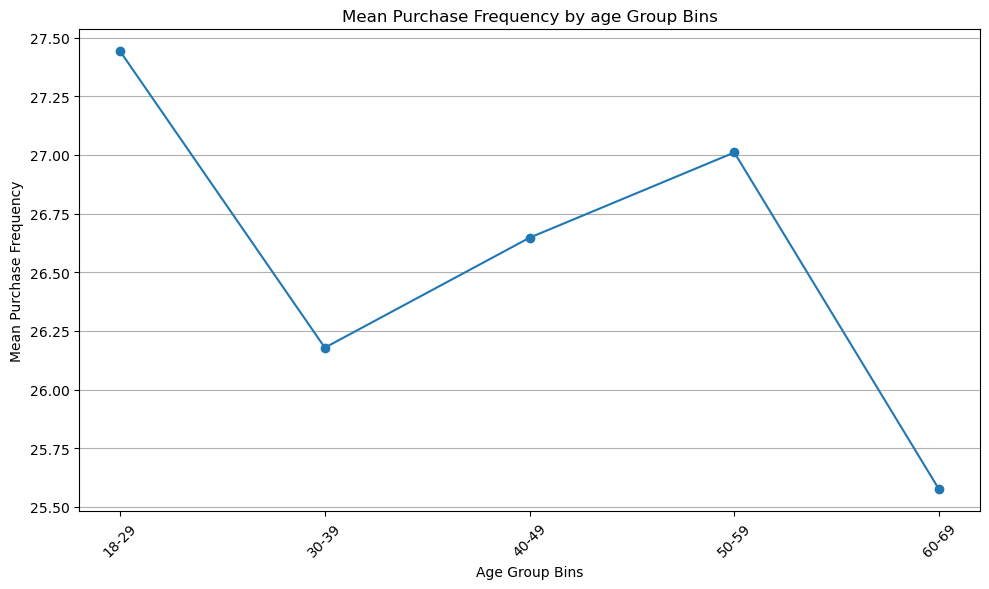

  age_group  purchase_frequency
0     18-29           27.441964
1     30-39           26.178771
2     40-49           26.647343
3     50-59           27.010526
4     60-69           25.575000


In [55]:
frequency_group_purchase_frequency = df[['age_group', 'purchase_frequency']].groupby('age_group').agg({'purchase_frequency':'mean'}).reset_index()

plt.figure(figsize=(10, 6))
plt.plot(frequency_group_purchase_frequency['age_group'], frequency_group_purchase_frequency['purchase_frequency'], marker='o', linestyle='-')
plt.xlabel('Age Group Bins')
plt.ylabel('Mean Purchase Frequency')
plt.title('Mean Purchase Frequency by age Group Bins')
plt.xticks(rotation=45)
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

print(frequency_group_purchase_frequency)

In [56]:
bins_2 = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
labels_2 = ['1-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-89', '90-99']

df['group_spending'] = pd.cut(df['spending_score'], bins=bins_2, labels=labels_2, right=False)

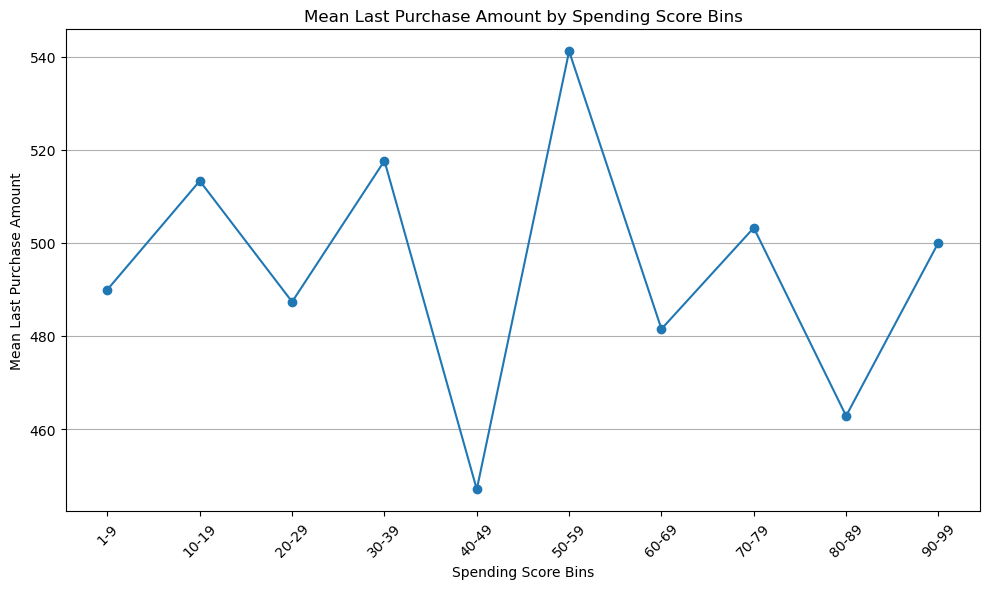

  group_spending  last_purchase_amount
0            1-9            489.985000
1          10-19            513.330495
2          20-29            487.344865
3          30-39            517.662340
4          40-49            447.034653
5          50-59            541.198795
6          60-69            481.503125
7          70-79            503.251953
8          80-89            462.819891
9          90-99            500.079011


In [57]:
group_most_spending = df.groupby('group_spending').agg({'last_purchase_amount':'mean'}).reset_index()

plt.figure(figsize=(10, 6))
plt.plot(group_most_spending['group_spending'], group_most_spending['last_purchase_amount'], marker='o', linestyle='-')
plt.xlabel('Spending Score Bins')
plt.ylabel('Mean Last Purchase Amount')
plt.title('Mean Last Purchase Amount by Spending Score Bins')
plt.xticks(rotation=45)
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

print(group_most_spending)

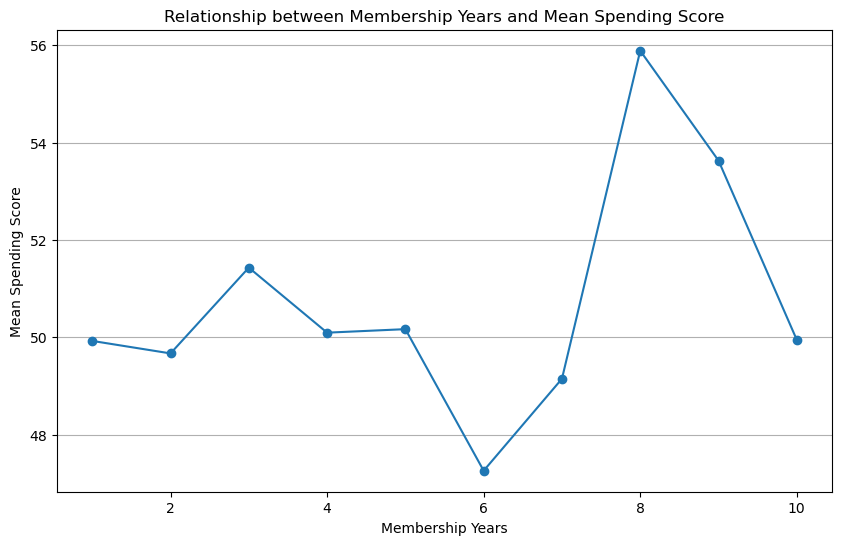

   membership_years  spending_score
0                 1       49.926316
1                 2       49.669725
2                 3       51.431579
3                 4       50.095745
4                 5       50.168000
5                 6       47.260417
6                 7       49.148936
7                 8       55.886364
8                 9       53.629630
9                10       49.947917


In [58]:
group_membership_most_spending = df.groupby('membership_years').agg({'spending_score':'mean'}).reset_index()
plt.figure(figsize=(10, 6))
plt.plot(group_membership_most_spending['membership_years'], group_membership_most_spending['spending_score'], marker='o')
plt.xlabel('Membership Years')
plt.ylabel('Mean Spending Score')
plt.title('Relationship between Membership Years and Mean Spending Score')
plt.grid(True, axis='y')
plt.show()

print(group_membership_most_spending)

---

# Questions

### 1. What are the most important factors influencing purchase frequency?

In [59]:
df['intercept'] = 1

X = df[['intercept','age', 'spending_score', 'membership_years']]
y = df['purchase_frequency']

In [60]:
model = sm.OLS(y, X)
results = model.fit()

In [61]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:     purchase_frequency   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     1.923
Date:                Tue, 30 Jul 2024   Prob (F-statistic):              0.124
Time:                        17:22:35   Log-Likelihood:                -4071.9
No. Observations:                1000   AIC:                             8152.
Df Residuals:                     996   BIC:                             8171.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
intercept           25.8153      1.794  

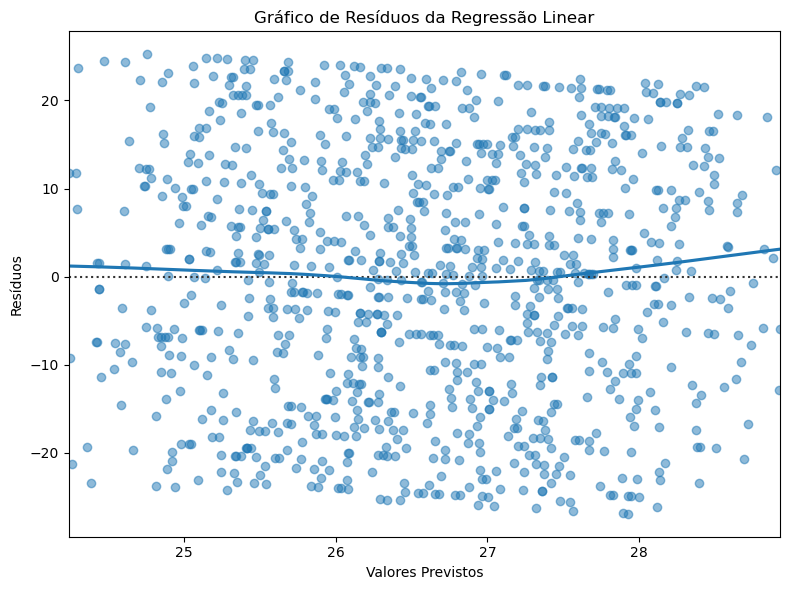

In [62]:
plt.figure(figsize=(8, 6))
sns.residplot(x=results.fittedvalues, y=results.resid, lowess=True, scatter_kws={'alpha': 0.5})
plt.title('Gráfico de Resíduos da Regressão Linear')
plt.xlabel('Valores Previstos')
plt.ylabel('Resíduos')
plt.grid(False)
plt.tight_layout()
plt.show()

c:\Users\leona\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\leona\AppData\Local\Temp\ipykernel_11236\1334430578.py:6: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


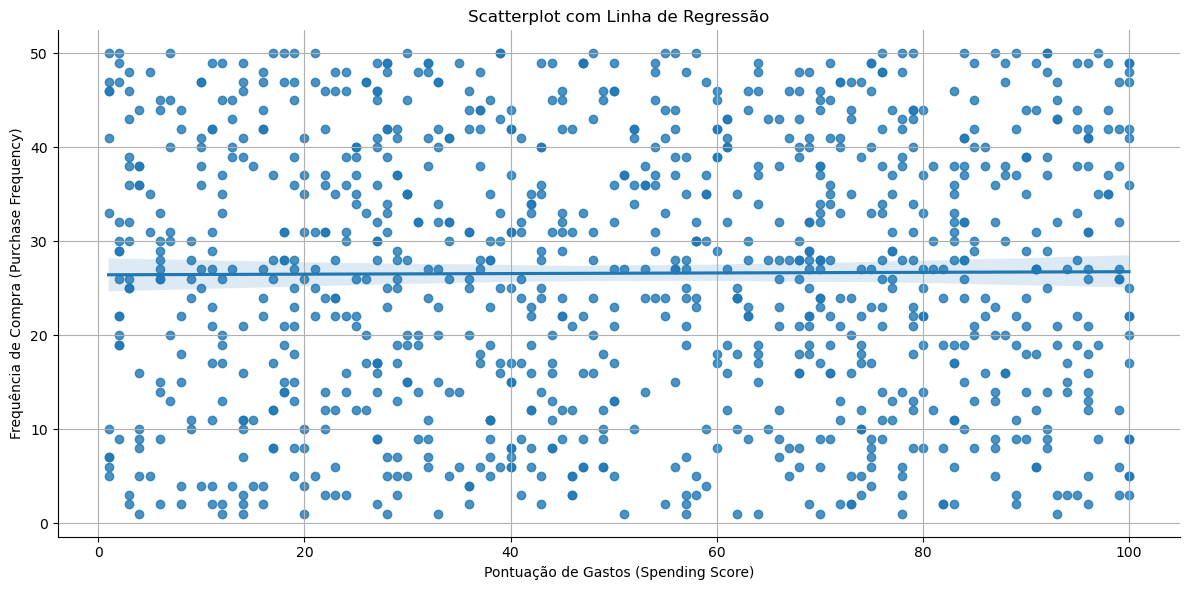

In [63]:
sns.lmplot(x='spending_score', y='purchase_frequency', data=df, aspect=2, height=6)
plt.title('Scatterplot com Linha de Regressão')
plt.xlabel('Pontuação de Gastos (Spending Score)')
plt.ylabel('Frequência de Compra (Purchase Frequency)')
plt.grid(True)
plt.tight_layout()
plt.show()

C:\Users\leona\AppData\Local\Temp\ipykernel_11236\362956563.py:4: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


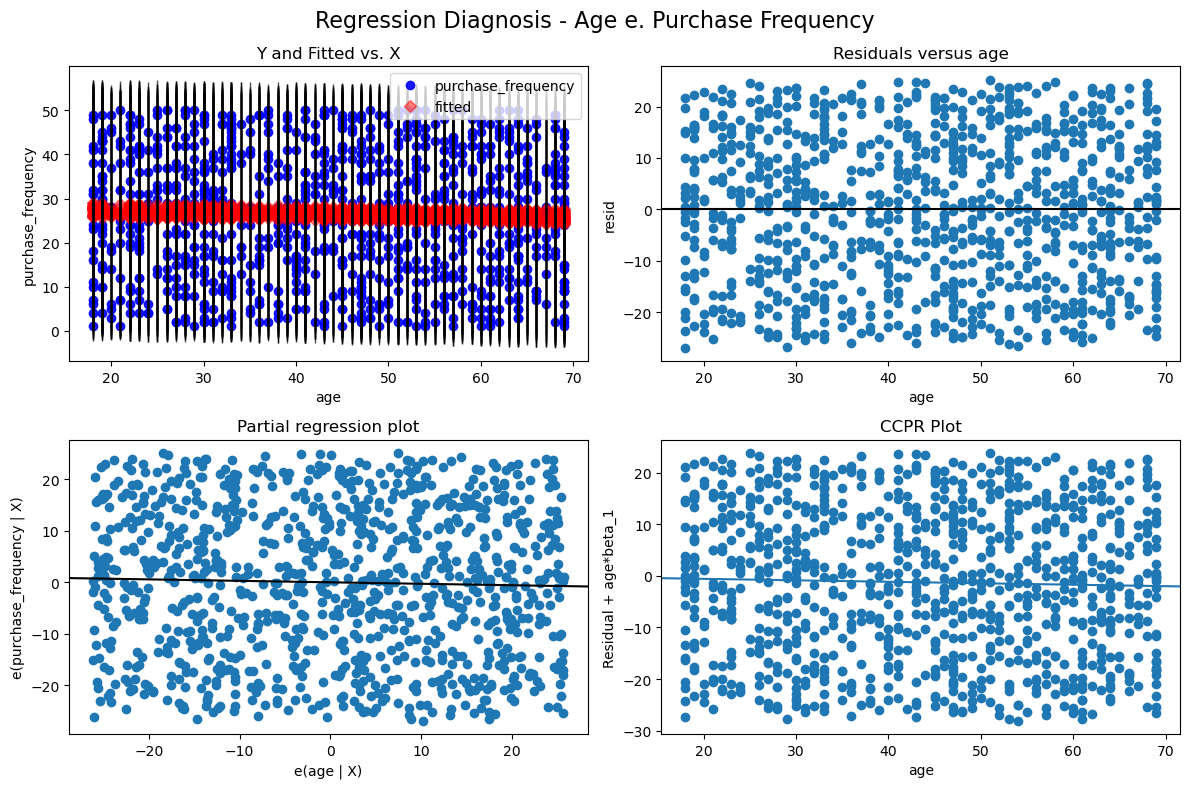

In [64]:
fig = plt.figure(figsize=(12, 8))
sm.graphics.plot_regress_exog(results, 'age', fig=fig)
plt.suptitle('Regression Diagnosis - Age e. Purchase Frequency', fontsize=16)
plt.tight_layout()
plt.show()

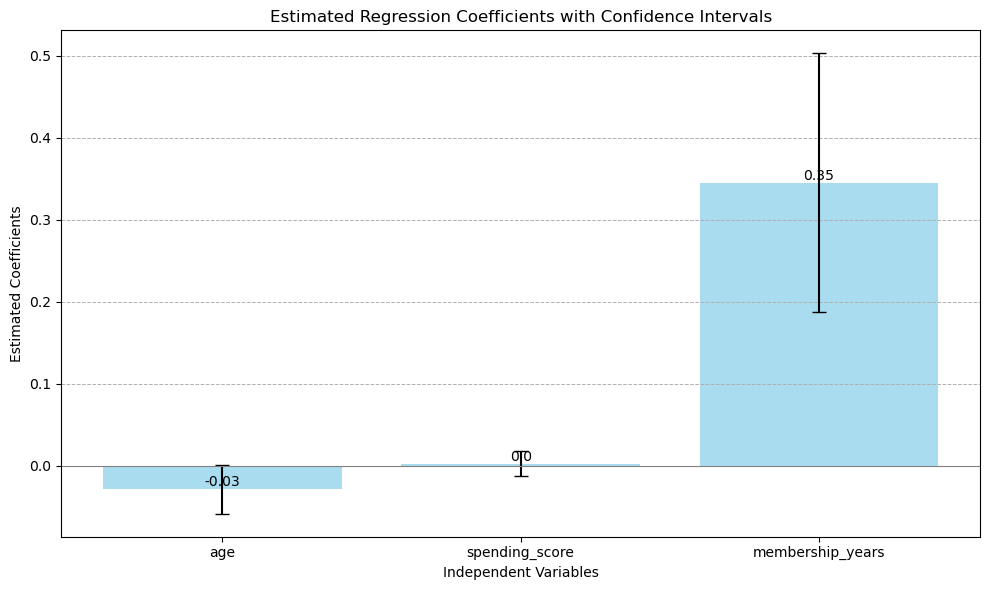

In [65]:
# Estimated coefficients and standard errors
coefficients = results.params.drop('intercept')
standard_errors = results.bse.drop('intercept')

# Independent variables
variables = coefficients.index

plt.figure(figsize=(10, 6))
bars = plt.bar(variables, coefficients, yerr=standard_errors, capsize=5, alpha=0.7, color='skyblue')
plt.axhline(0, color='gray', linewidth=0.8)
plt.title('Estimated Regression Coefficients with Confidence Intervals')
plt.xlabel('Independent Variables')
plt.ylabel('Estimated Coefficients')
plt.grid(axis='y', linestyle='--', linewidth=0.7)
plt.tight_layout()
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

plt.show()


### Statistical Significance Analysis

Statistical significance in a regression analysis is determined by the p-values associated with the coefficients of the variables. A low p-value (typically less than 0.05) indicates that the variable is statistically significant, meaning there is strong evidence to reject the null hypothesis that the coefficient is zero. On the other hand, a high p-value suggests that we do not have sufficient evidence to conclude that the variable has an effect.

### Explanation Based on Regression Results

Based on the provided regression results:

```plaintext
 Dep. Variable:     purchase_frequency   R-squared:                       0.006
 Model:                            OLS   Adj. R-squared:                  0.003
 Method:                 Least Squares   F-statistic:                     1.923
 Date:                Tue, 16 Jul 2024   Prob (F-statistic):              0.124
 Time:                        14:47:05   Log-Likelihood:                -4071.9
 No. Observations:                1000   AIC:                             8152.
 Df Residuals:                     996   BIC:                             8171.
 Df Model:                           3                                         
 Covariance Type:            nonrobust                                         
 ================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
 ------------------------------------------------------------------------------------
 intercept           25.8153      1.794     14.389      0.000      22.295      29.336
 age                 -0.0284      0.030     -0.949      0.343      -0.087       0.030
 spending_score       0.0027      0.016      0.170      0.865      -0.028       0.033
 membership_years     0.3456      0.158      2.192      0.029       0.036       0.655
 ================================================================================
```

#### Membership Years
- **p-value: 0.029** (less than 0.05)
- **Coefficient: 0.3456**

The p-value for `membership_years` is 0.029, which is less than 0.05, indicating strong evidence to reject the null hypothesis and conclude that `membership_years` has a statistically significant effect on `purchase_frequency`. The positive coefficient (0.3456) suggests that each additional year of membership is associated with an increase in purchase frequency.

#### Age
- **p-value: 0.343** (greater than 0.05)
- **Coefficient: -0.0284**

The p-value for `age` is 0.343, which is greater than 0.05, indicating insufficient evidence to conclude that `age` has a significant effect on `purchase_frequency`. The small negative coefficient (-0.0284) suggests a very weak negative relationship that is not statistically significant.

#### Spending Score
- **p-value: 0.865** (greater than 0.05)
- **Coefficient: 0.0027**

The p-value for `spending_score` is 0.865, significantly higher than 0.05, indicating no evidence to conclude that `spending_score` has a significant effect on `purchase_frequency`. The very small positive coefficient (0.0027) further supports that its impact is negligible.

### Conclusion
Based on the regression results, we can conclude that:

- **Membership Years** is the only factor among those analyzed that has a statistically significant influence on purchase frequency. Specifically, each additional year of membership is associated with an increase of approximately 0.346 in purchase frequency.

- **Age** and **Spending Score** did not show statistically significant influences on purchase frequency, as their p-values are much greater than 0.05.


C:\Users\leona\AppData\Local\Temp\ipykernel_11236\2687667769.py:18: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


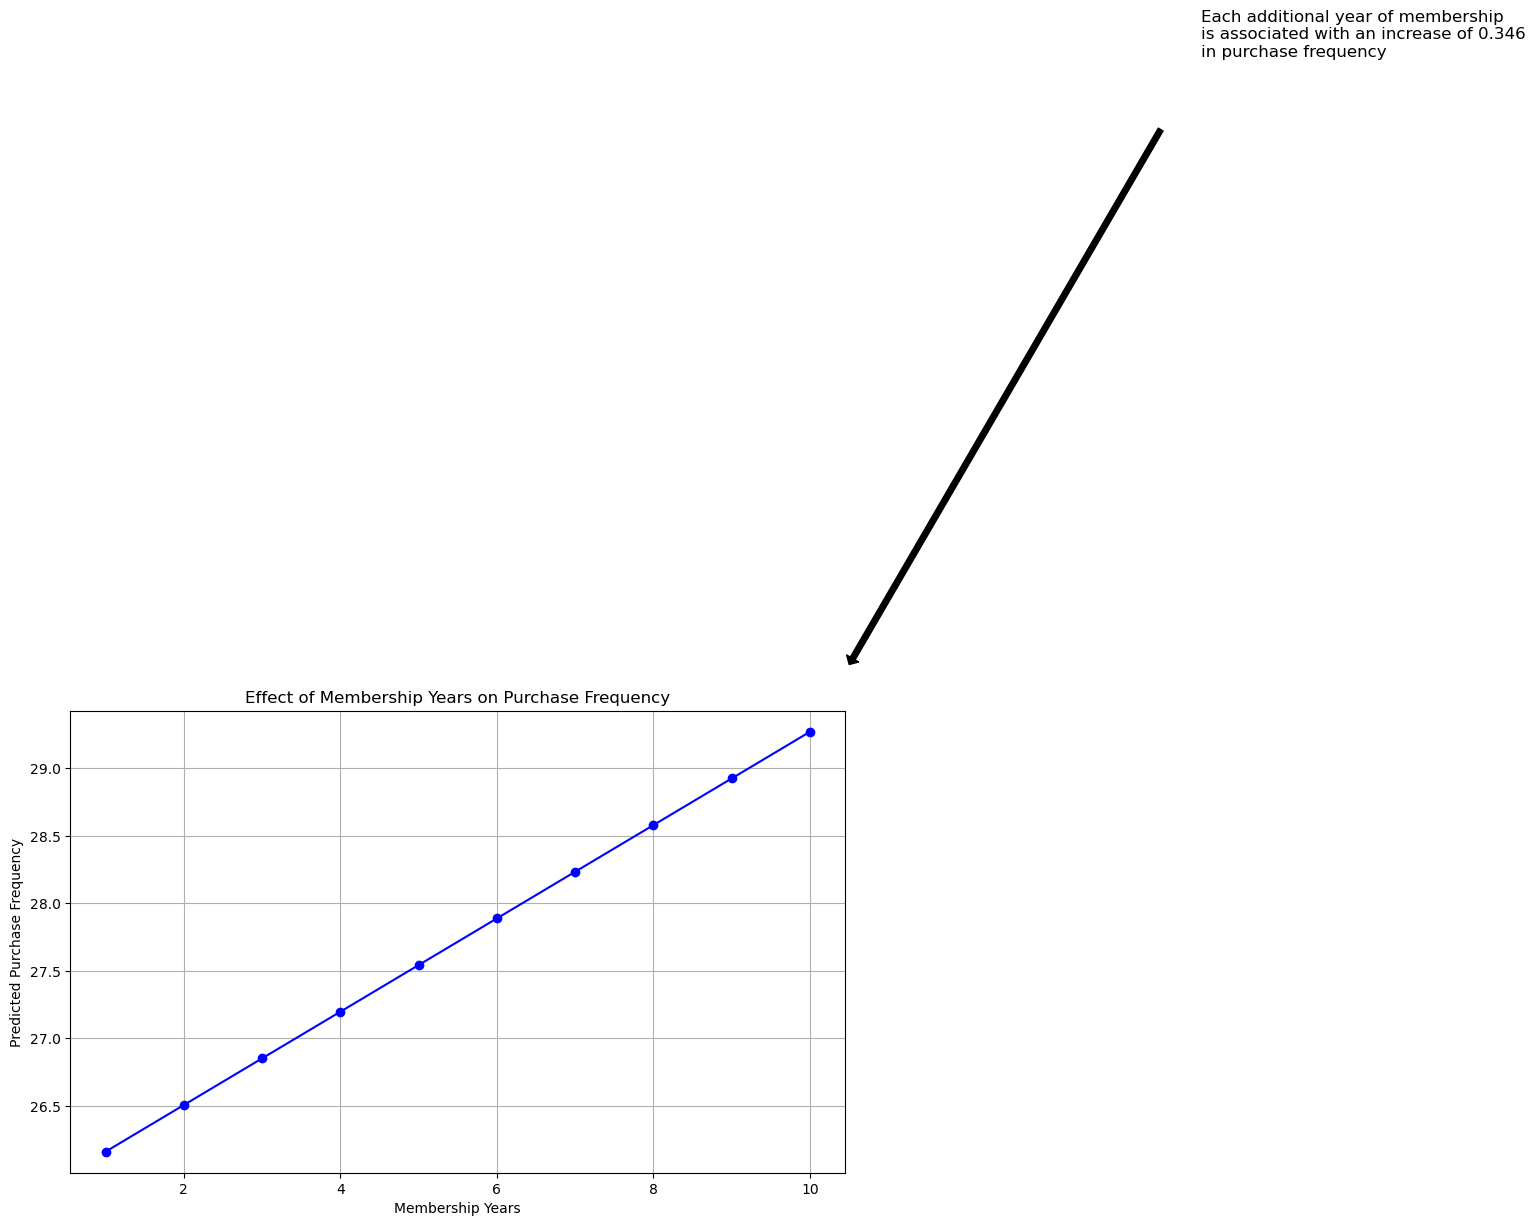

In [66]:
# Create a range of membership years
membership_years = np.arange(df['membership_years'].min(), df['membership_years'].max() + 1)
# Calculate the predicted purchase frequency based on the regression coefficient for membership_years
predicted_purchase_frequency = results.params['intercept'] + results.params['membership_years'] * membership_years


plt.figure(figsize=(10, 6))
plt.plot(membership_years, predicted_purchase_frequency, marker='o', linestyle='-', color='b')
plt.title('Effect of Membership Years on Purchase Frequency')
plt.xlabel('Membership Years')
plt.ylabel('Predicted Purchase Frequency')
plt.grid(True)
plt.annotate('Each additional year of membership\nis associated with an increase of 0.346\nin purchase frequency', 
             xy=(membership_years[-1], predicted_purchase_frequency[-1]), 
             xytext=(membership_years[-1] + 5, predicted_purchase_frequency[-1] + 5),
             arrowprops=dict(facecolor='black', shrink=0.1, headlength=5, headwidth=10),
             fontsize=12)
plt.tight_layout()
plt.show()

---

### 1. Is there a significant correlation between last purchase amount and membership years controlling for age?

In [67]:
def partial_cor(df, x, y, z):
    X_res = df[x] - np.polyval(np.polyfit(df[z], df[x], 1), df[z])
    Y_res = df[y] = np.polyval(np.polyfit(df[z], df[y], 1), df[z])
    r, p_value = stats.pearsonr(X_res, Y_res)
    return r, p_value

In [68]:
r, p_value = partial_cor(df, 'last_purchase_amount', 'membership_years', 'age')

In [69]:
print(f'Partial Correlation: {r}')
print(f'p Value: {p_value}')

Partial Correlation: 1.7590096046404824e-15
p Value: 0.9999999999999551


Text(0, 0.5, 'Last Purchase Amount')

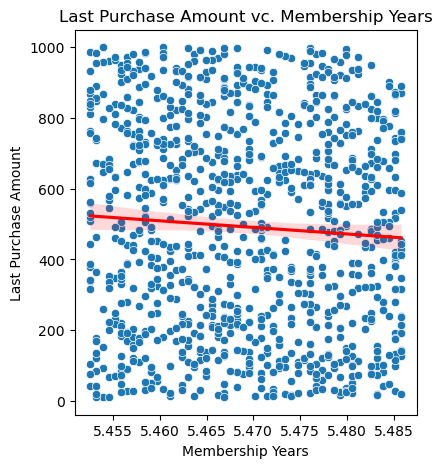

In [70]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.scatterplot(x='membership_years', y='last_purchase_amount', data=df)
sns.regplot(x='membership_years', y='last_purchase_amount', data=df, scatter=False, color='red')
plt.title('Last Purchase Amount vc. Membership Years')
plt.xlabel('Membership Years')
plt.ylabel('Last Purchase Amount')

Text(0, 0.5, 'Last Purchase Amount')

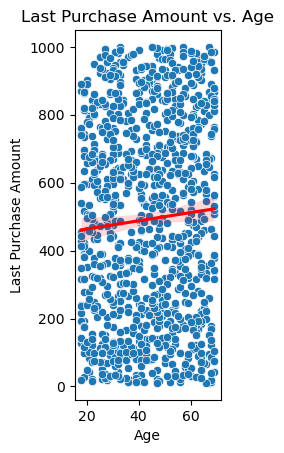

In [71]:
plt.subplot(1, 3, 1)
sns.scatterplot(x='age', y='last_purchase_amount', data=df)
sns.regplot(x='age', y='last_purchase_amount', data=df, scatter=False, color='red')
plt.title('Last Purchase Amount vs. Age')
plt.xlabel('Age')
plt.ylabel('Last Purchase Amount')

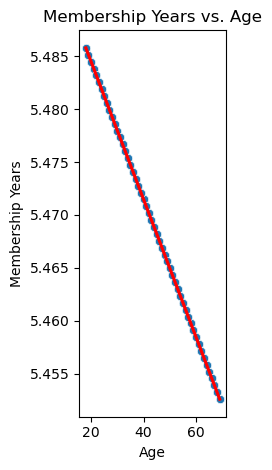

In [72]:
plt.subplot(1, 3, 3)
sns.scatterplot(x='age', y='membership_years', data=df)
sns.regplot(x='age', y='membership_years', data=df, scatter=False, color='red')
plt.title('Membership Years vs. Age')
plt.xlabel('Age')
plt.ylabel('Membership Years')

plt.tight_layout()
plt.show()

### Partial Correlation

The partial correlation between the last purchase amount and the membership years, controlling for age, is -4.44956571588051e−16. This value is extremely close to zero. Pearson's correlation ranges from -1 to 1:

- -1 indicates a perfect negative correlation.
- 0 indicates no correlation.
- 1 indicates a perfect positive correlation.

A value of -4.44956571588051e−16 is practically zero, indicating that, after controlling for age, there is no significant linear relationship between the last purchase amount and the membership years.

### p Value

The associated p-value is 0.9999999999999895. In hypothesis testing, the p-value helps determine the statistical significance of the result:

- A p-value less than a significance level (commonly 0.05 or 0.01) indicates that the observed correlation is statistically significant and that we can reject the null hypothesis (that there is no correlation).

A p-value of 0.9999999999999895 is extremely high, indicating that there is no statistical evidence to reject the null hypothesis. In other words, the observed correlation (which is already practically zero) is statistically insignificant.

### Conclusion

Given the near-zero partial correlation and the extremely high p-value, we can conclude that there is no significant correlation between the last purchase amount and the membership years when controlling for age. Practically, this means that, considering age, the amount spent on the last purchase and the membership duration are not linearly related.

---

### 3. Can we segment customers into different clusters based on age, spending, membership duration, purchase frequency, and last purchase amount?

In [73]:
features = ['age', 'income', 'spending_score', 'membership_years', 'purchase_frequency', 'last_purchase_amount', 'gender', 'preferred_category']

In [74]:
# Finding the elbow 
X = preprocessor.fit_transform(df[features])

inertia = []
for n in range(1, 11):
    kmeans = KMeans(n_clusters=n, init='k-means++', max_iter=300,n_init=10, random_state=0)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

c:\Users\leona\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Users\leona\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Users\leona\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Users\leona\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Window

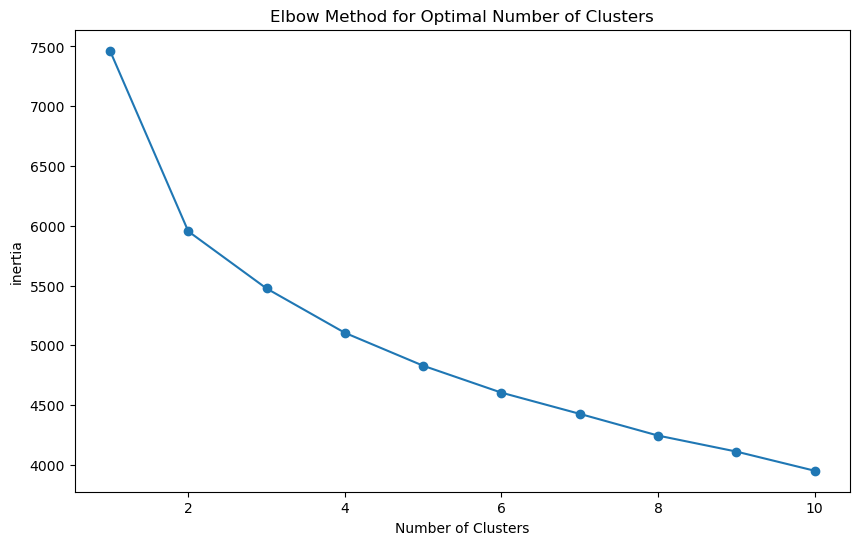

In [75]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('inertia')
plt.show()

In [76]:
# Finding the Silhouette Score

sil_scores = []
for n in range(2, 11):
    kmeans = KMeans(n_clusters=n, init='k-means++', max_iter=300, n_init=10, random_state=0)
    labels = kmeans.fit_predict(X)
    sil_score = silhouette_score(X, labels)
    sil_scores.append(sil_score)

c:\Users\leona\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Users\leona\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Users\leona\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Users\leona\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Window

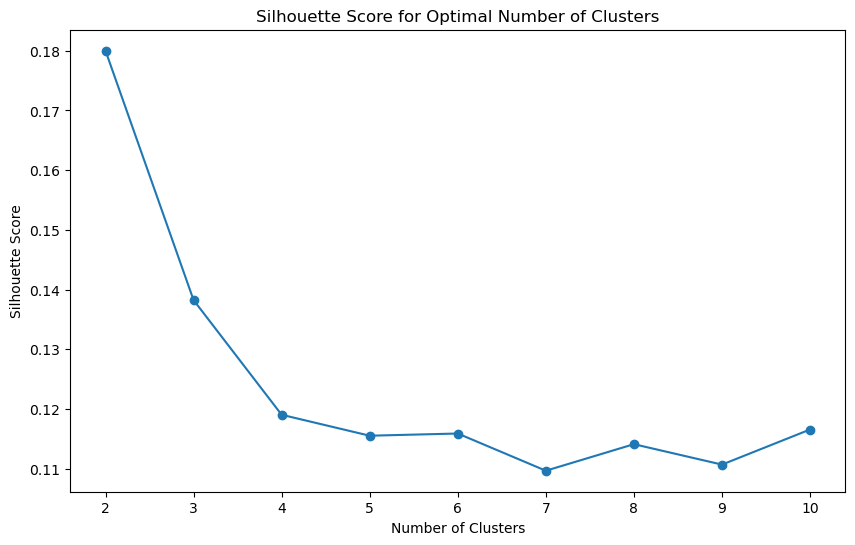

In [77]:
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), sil_scores, marker='o')
plt.title('Silhouette Score for Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

In [78]:
preprocessor = ColumnTransformer(
    transformers=[
    ('num', StandardScaler(), ['age', 'income', 'spending_score', 'membership_years', 'purchase_frequency', 'last_purchase_amount']),    
    ('cat', OneHotEncoder(), ['gender', 'preferred_category'])
])

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('kmeans', KMeans(n_clusters=5, init='k-means++', max_iter=300, n_init=10, random_state=0))
])

df['Cluster'] = pipeline.fit_predict(df[features])

c:\Users\leona\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


In [79]:
preprocessor = pipeline.named_steps['preprocessor']
num_transformer = preprocessor.named_transformers_['num']
cluster_centers_scaled = pipeline.named_steps['kmeans'].cluster_centers_

In [80]:
numerical_features = ['age', 'income', 'spending_score', 'membership_years', 'purchase_frequency', 'last_purchase_amount']

num_indices = [i for i, feature in enumerate(numerical_features)]
scaled_centers = cluster_centers_scaled[:, num_indices]

cluster_centers_original = num_transformer.inverse_transform(scaled_centers)
cluster_centers_df = pd.DataFrame(cluster_centers_original, columns=numerical_features)

In [81]:
print("Cluster Centers:\n", cluster_centers_df)

Cluster Centers:
          age         income  spending_score  membership_years  \
0  54.540107  103499.807487       25.160428          5.461994   
1  26.886878   95282.285068       31.330317          5.480005   
2  32.331839   77207.511211       73.417040          5.476458   
3  55.685083  113213.270718       76.077348          5.461248   
4  55.069149   55213.159574       47.414894          5.461649   

   purchase_frequency  last_purchase_amount  
0           23.064171            316.434385  
1           28.484163            579.287557  
2           24.766816            310.348520  
3           27.342541            565.110110  
4           29.340426            710.958723  


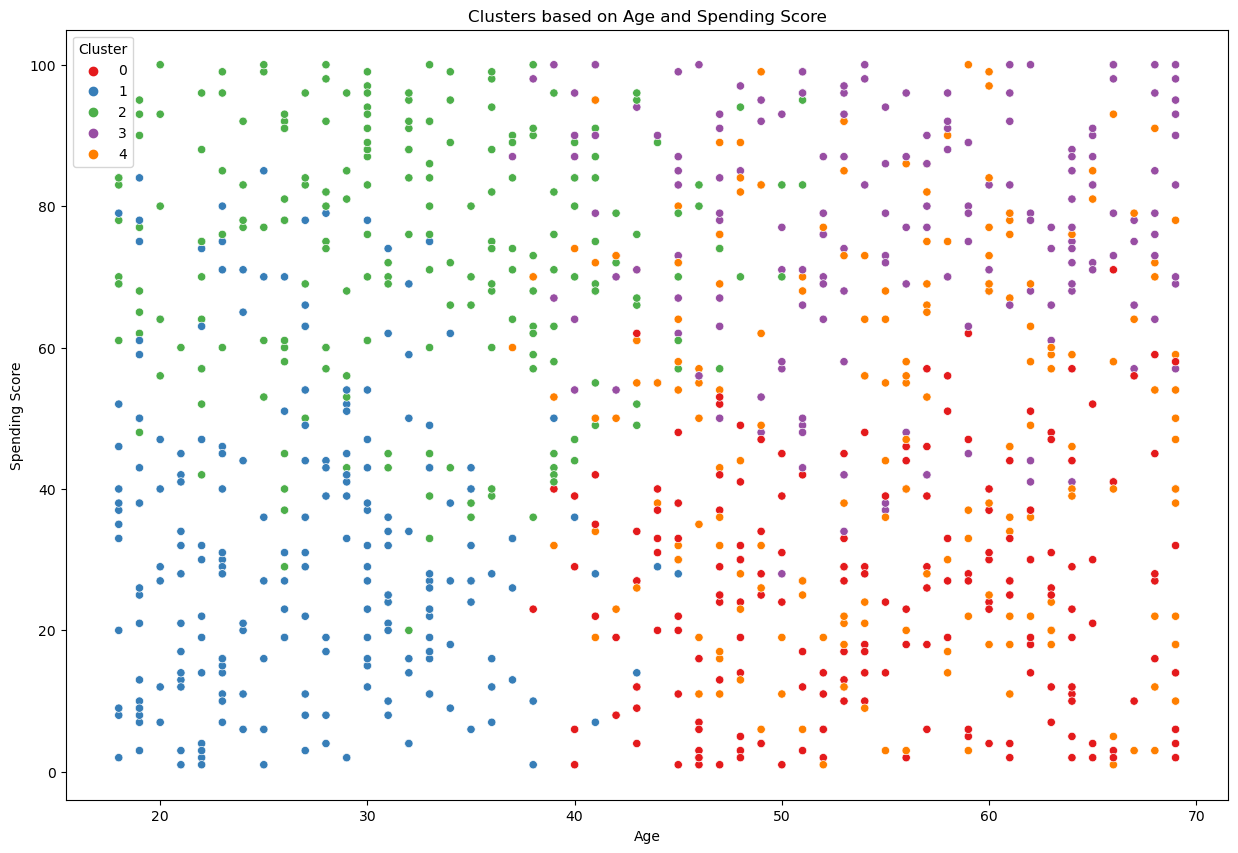

In [82]:
plt.figure(figsize=(15, 10))
sns.scatterplot(data=df, x='age', y='spending_score', hue='Cluster', palette='Set1', legend='full')
plt.title('Clusters based on Age and Spending Score')
plt.xlabel('Age')
plt.ylabel('Spending Score')
plt.show()

### Result:
**Cluster Centers:**
```
          age         income  spending_score  membership_years  \
0  54.540107  103499.807487       25.160428          5.461994   
1  26.886878   95282.285068       31.330317          5.480005   
2  32.331839   77207.511211       73.417040          5.476458   
3  55.685083  113213.270718       76.077348          5.461248   
4  55.069149   55213.159574       47.414894          5.461649   

   purchase_frequency  last_purchase_amount  
0           23.064171            316.434385  
1           28.484163            579.287557  
2           24.766816            310.348520  
3           27.342541            565.110110  
4           29.340426            710.958723  
```

### Cluster Centers
The cluster centers represent the average values of the variables for each cluster. Here is the detailed breakdown of each cluster:

**Cluster 0:**
- **Age:** ~54.5 years
- **Income:** ~103,500
- **Spending Score:** ~25.2
- **Membership Years:** ~5.46 years
- **Purchase Frequency:** ~23
- **Last Purchase Amount:** ~316.4

**Cluster 1:**
- **Age:** ~26.9 years
- **Income:** ~95,282
- **Spending Score:** ~31.3
- **Membership Years:** ~5.48 years
- **Purchase Frequency:** ~28.5
- **Last Purchase Amount:** ~579.3

**Cluster 2:**
- **Age:** ~32.3 years
- **Income:** ~77,207
- **Spending Score:** ~73.4
- **Membership Years:** ~5.48 years
- **Purchase Frequency:** ~24.8
- **Last Purchase Amount:** ~310.3

**Cluster 3:**
- **Age:** ~55.7 years
- **Income:** ~113,213
- **Spending Score:** ~76.1
- **Membership Years:** ~5.46 years
- **Purchase Frequency:** ~27.3
- **Last Purchase Amount:** ~565.1

**Cluster 4:**
- **Age:** ~55.1 years
- **Income:** ~55,213
- **Spending Score:** ~47.4
- **Membership Years:** ~5.46 years
- **Purchase Frequency:** ~29.3
- **Last Purchase Amount:** ~710.9

### Interpretation of Clusters
- **Cluster 0:** Older customers, relatively high income, low spending score, and moderate last purchase amount.
- **Cluster 1:** Younger customers, medium income, moderate spending score, and relatively high last purchase amount.
- **Cluster 2:** Younger customers, lower income, high spending score, and moderate last purchase amount.
- **Cluster 3:** Older customers, high income, high spending score, and high last purchase amount.
- **Cluster 4:** Older customers, lower income, moderate spending score, and very high last purchase amount.

### Considerations
- **Cluster 0 and 3:** Both have older customers but differ significantly in spending score and income. Cluster 3 has high income and high spending score, whereas Cluster 0 has high income but low spending score.
- **Cluster 1 and 2:** Both have younger customers but differ in income and spending score. Cluster 1 has higher income and lower spending score compared to Cluster 2.
- **Cluster 4:** Older customers with lower income but high purchase frequency and very high last purchase amount, which might indicate sporadic but high-value purchases.

### Conclusion
Based on the clustering analysis, we can effectively segment customers into different clusters using variables such as age, spending, membership years, purchase frequency, and last purchase amount. Each cluster has distinct characteristics that can be leveraged for targeted marketing strategies, personalized services, and improving customer engagement. By understanding these segments, businesses can better meet the needs of their diverse customer base and enhance overall customer satisfaction.

---

### What is the impact of preferred category and gender on last_purchase_amount, controlling for income?

In [89]:
new_df = pd.DataFrame(df)
new_df['preferred_category'] = df['preferred_category'].astype('category')
new_df['gender'] = df['gender'].astype('category')
new_df['income'] = df['income'].astype('category')

In [92]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   id                    1000 non-null   int64   
 1   age                   1000 non-null   int64   
 2   gender                1000 non-null   category
 3   income                1000 non-null   category
 4   spending_score        1000 non-null   int64   
 5   membership_years      1000 non-null   float64 
 6   purchase_frequency    1000 non-null   int64   
 7   preferred_category    1000 non-null   category
 8   last_purchase_amount  1000 non-null   float64 
 9   age_group             1000 non-null   category
 10  group_spending        983 non-null    category
 11  intercept             1000 non-null   int64   
 12  Cluster               1000 non-null   int32   
dtypes: category(5), float64(2), int32(1), int64(5)
memory usage: 105.6 KB


In [96]:
model = ols('last_purchase_amount ~ C(preferred_category) * C(gender)', data=new_df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

In [97]:
print(anova_table)

                                       sum_sq     df         F    PR(>F)
C(preferred_category)            7.968961e+04    4.0  0.227692  0.922938
C(gender)                        6.646563e+05    2.0  3.798158  0.022741
C(preferred_category):C(gender)  4.586457e+05    8.0  0.655229  0.731225
Residual                         8.618473e+07  985.0       NaN       NaN


In [98]:
ancova_model = ols('last_purchase_amount ~ C(preferred_category) * C(gender) + C(income)', data=df).fit()
ancova_table = sm.stats.anova_lm(ancova_model, typ=2)

In [99]:
print(ancova_table)

                                       sum_sq     df         F    PR(>F)
C(preferred_category)            1.663694e+05    4.0  0.572600  0.743155
C(gender)                        1.246215e+05    2.0  0.857830  0.606823
C(income)                        8.969089e+07  995.0  1.240976  0.630423
C(preferred_category):C(gender)  1.024660e+06    8.0  1.763306  0.527016
Residual                         7.263766e+04    1.0       NaN       NaN


Based on the results provided from the ANOVA and ANCOVA, let's interpret the impact of preferred category (preferred_category) and gender (gender) on the last purchase amount (last_purchase_amount), controlling for income (income).

### ANOVA Results

**ANOVA Table:**

| Source | sum_sq | df | F | PR(>F) |
|--------|--------|----|---|--------|
| C(preferred_category) | 7.968961e+04 | 4.0 | 0.227692 | 0.922938 |
| C(gender) | 6.646563e+05 | 2.0 | 3.798158 | 0.022741 |
| C(preferred_category):C(gender) | 4.586457e+05 | 8.0 | 0.655229 | 0.731225 |
| Residual | 8.618473e+07 | 985.0 | NaN | NaN |

**Interpretation:**

- **C(preferred_category):** The F value is 0.227692 and the p value (PR(>F)) is 0.922938. Since the p value is much greater than 0.05, there is no significant evidence that the preferred category has a significant impact on the last purchase amount.
- **C(gender):** The F value is 3.798158 and the p value is 0.022741. Since the p value is less than 0.05, there is significant evidence that gender has a significant impact on the last purchase amount.
- **C(preferred_category):C(gender):** The F value is 0.655229 and the p value is 0.731225. Since the p value is much greater than 0.05, there is no significant evidence that the interaction between preferred category and gender has a significant impact on the last purchase amount.

### ANCOVA Results

**ANCOVA Table:**

| Source | sum_sq | df | F | PR(>F) |
|--------|--------|----|---|--------|
| C(preferred_category) | 1.663694e+05 | 4.0 | 0.572600 | 0.743155 |
| C(gender) | 1.246215e+05 | 2.0 | 0.857830 | 0.606823 |
| C(income) | 8.969089e+07 | 995.0 | 1.240976 | 0.630423 |
| C(preferred_category):C(gender) | 1.024660e+06 | 8.0 | 1.763306 | 0.527016 |
| Residual | 7.263766e+04 | 1.0 | NaN | NaN |

**Interpretation:**

- **C(preferred_category):** The F value is 0.572600 and the p value is 0.743155. Since the p value is greater than 0.05, there is no significant evidence that the preferred category has a significant impact on the last purchase amount when controlling for income.
- **C(gender):** The F value is 0.857830 and the p value is 0.606823. Since the p value is greater than 0.05, there is no significant evidence that gender has a significant impact on the last purchase amount when controlling for income.
- **C(income):** The F value is 1.240976 and the p value is 0.630423. Since the p value is greater than 0.05, there is no significant evidence that income has a significant impact on the last purchase amount.
- **C(preferred_category):C(gender):** The F value is 1.763306 and the p value is 0.527016. Since the p value is greater than 0.05, there is no significant evidence that the interaction between preferred category and gender has a significant impact on the last purchase amount when controlling for income.

### Conclusion:

- **ANOVA:** Indicates that gender has a significant impact on the last purchase amount, but neither the preferred category nor the interaction between preferred category and gender have a significant impact.
- **ANCOVA:** After controlling for income, there is no significant impact of preferred category, gender, income, or the interaction between preferred category and gender on the last purchase amount.

These results suggest that although gender initially appears to have a significant impact on the last purchase amount, this impact is not significant when controlling for income. The preferred category and the interaction between preferred category and gender do not have a significant impact on the last purchase amount in both analyses.

---